In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!nvidia-smi

Tue Jun  1 18:19:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
ls

drive/  sample_data/


In [4]:
cd drive/MyDrive/

/content/drive/MyDrive


In [5]:
ls

 0002cc93b.jpg.txt                  malikbhai/   PTQ/      video_class/
'Codebugged Official Repository'/   MRV/         QAT/      YOLO/
'Colab Notebooks'/                  NVIDIA/      TRT-OP/


In [8]:
mkdir QAT

mkdir: cannot create directory ‘QAT’: File exists


In [6]:
cd QAT

/content/drive/MyDrive/QAT


## Installing Necessary Libraries

### TF-Nightly - A version of tensorflow resolving build failure

In [7]:
!pip uninstall tensorflow
!pip install tf-nightly
!pip install tensorflow-model-optimization

Uninstalling tensorflow-2.5.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.5.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 454.4MB 37kB/s 
     |████████████████████████████████| 5.9MB 29.2MB/s 
     |████████████████████████████████| 1.3MB 41.5MB/s 
     |████████████████████████████████| 4.2MB 31.0MB/s 
     |████████████████████████████████| 471kB 44.4MB/s 
  Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Found existing installation: keras-nightly 2.5.0.dev2021032900
    Uninstalling

In [ ]:
#Data Gathering from Google API 
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip 
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip

--2021-05-30 19:05:47--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 108.177.98.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M  61.4MB/s    in 3.1s    

2021-05-30 19:05:50 (61.4 MB/s) - ‘rps.zip’ saved [200682221/200682221]

--2021-05-30 19:05:50--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps-test-set.zi

In [ ]:
!unzip -q rps.zip
!unzip -qq rps-test-set.zip

In [8]:
from imutils import paths
from pprint import pprint
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model
import tensorflow_model_optimization as tfmot
import re 

import os
from sys import getsizeof
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import accuracy_score
from sys import getsizeof

import numpy as np
np.random.seed(42)


print(tf.__version__)

2.6.0-dev20210601


In [9]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File Size: ' + str(round(size/1024, 3)) + 'Kilobytes')
    elif unit == 'MB':
        return print('File Size: ' + str(round(size/(1024*1024), 3)) + 'Megabytes')
    else:
        return print('File Size: ' + str(size) + 'bytes')

In [10]:
train_dir='rps/'
test_dir='rps-test-set/'

In [11]:
image_paths = list(paths.list_images("rps"))
np.random.shuffle(image_paths)
image_paths[:5]

['rps/scissors/scissors02-076.png',
 'rps/rock/rock02-026.png',
 'rps/rock/rock03-010.png',
 'rps/scissors/scissors04-027.png',
 'rps/paper/paper05-061.png']

In [12]:
#Counting images per class
labels = []
for image_path in image_paths:
    label = image_path.split("/")[1]
    labels.append(label)
class_count = Counter(labels) 
pprint(class_count)

Counter({'scissors': 840, 'rock': 840, 'paper': 840})


In [13]:
#Defining Hyperparameters
BATCH_SIZE = 128
EPOCHS = 20
IMG_SIZE = 150
NUM_CLASSES=3

In [14]:
training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')


validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(IMG_SIZE,IMG_SIZE),
	class_mode='categorical',
    batch_size=BATCH_SIZE
)

validation_generator = validation_datagen.flow_from_directory(
	test_dir,
	target_size=(IMG_SIZE,IMG_SIZE),
	class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [15]:
train_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}

In [16]:
#Defining the model
def training_model():
    model = Sequential([
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The third convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The fourth convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')                       
    ])
    return model

In [21]:
model = training_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Compiling and training the Baseline Model

In [ ]:
#Compile the Model
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

#Train the Model
history = model.fit(train_generator, epochs=EPOCHS, validation_data = validation_generator, validation_steps=3, batch_size=BATCH_SIZE)

Epoch 1/20
20/20 [==============================] - 158s 8s/step - loss: 1.3244 - accuracy: 0.3381 - val_loss: 1.0780 - val_accuracy: 0.4839
Epoch 2/20
20/20 [==============================] - 154s 8s/step - loss: 1.1145 - accuracy: 0.3726 - val_loss: 1.0640 - val_accuracy: 0.4113
Epoch 3/20
20/20 [==============================] - 150s 7s/step - loss: 1.1020 - accuracy: 0.4071 - val_loss: 1.0900 - val_accuracy: 0.3387
Epoch 4/20
20/20 [==============================] - 149s 7s/step - loss: 1.0655 - accuracy: 0.4389 - val_loss: 1.0041 - val_accuracy: 0.5645
Epoch 5/20
20/20 [==============================] - 149s 7s/step - loss: 1.0456 - accuracy: 0.4901 - val_loss: 1.0005 - val_accuracy: 0.5081
Epoch 6/20
20/20 [==============================] - 148s 7s/step - loss: 0.9125 - accuracy: 0.5611 - val_loss: 0.5844 - val_accuracy: 0.6989
Epoch 7/20
20/20 [==============================] - 148s 7s/step - loss: 0.9639 - accuracy: 0.5770 - val_loss: 0.7455 - val_accuracy: 0.5860
Epoch 8/20
20

In [ ]:
#Evaluating BaseLine model
test_loss, test_acc = model.evaluate(validation_generator, verbose=1)
print('Test Accuracy:', test_acc)
print('Test Loss:', test_loss)

3/3 [==============================] - 6s 2s/step - loss: 0.1040 - accuracy: 0.9731
Test Accuracy: 0.9731183052062988
Test Loss: 0.10402872413396835


###  Plot the Acc and Loss Curve

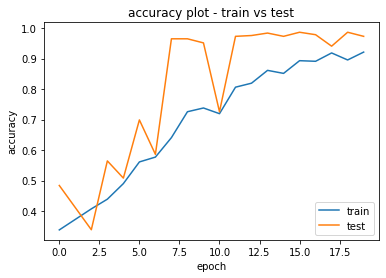

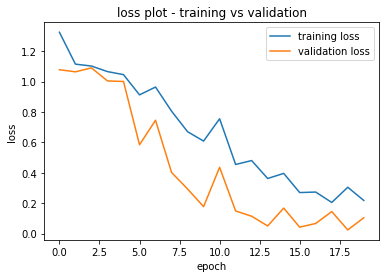

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('accuracy plot - train vs test')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs validation')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

### Saving our Baseline Model

In [ ]:
model.save('rps_model') #for making tflite
model.save('rps.h5')

INFO:tensorflow:Assets written to: rps_model/assets


In [17]:
ls

model.png  rps_model/     rps-test-set.zip    rps.zip.1
rps/       rps.tar.gz     rps-test-set.zip.1  tf_lite_model_rps.tflite
rps.h5     rps-test-set/  rps.zip             tf_lite_quant_model_rps.tflite


In [40]:
from keras.models import load_model

In [47]:
model = training_model() ##
model.load_weights('rps.h5')

In [48]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
!du -lh rps_model

27M	rps_model/variables
4.0K	rps_model/assets
27M	rps_model


In [25]:
convert_bytes(get_file_size('rps.h5'), "MB")

File Size: 26.557Megabytes


In [21]:
!tar cvf rps.tar.gz rps_model rps.h5

rps_model/
rps_model/variables/
rps_model/variables/variables.data-00000-of-00001
rps_model/variables/variables.index
tar: rps_model/variables: file changed as we read it
rps_model/assets/
rps_model/saved_model.pb
rps_model/keras_metadata.pb
rps.h5


### Quantizing our model

In [49]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

q_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
quantize_layer_1 (QuantizeLa (None, 150, 150, 3)       3         
_________________________________________________________________
quant_conv2d_8 (QuantizeWrap (None, 148, 148, 64)      1923      
_________________________________________________________________
quant_max_pooling2d_8 (Quant (None, 74, 74, 64)        1         
_________________________________________________________________
quant_conv2d_9 (QuantizeWrap (None, 72, 72, 64)        37059     
_________________________________________________________________
quant_max_pooling2d_9 (Quant (None, 36, 36, 64)        1         
_________________________________________________________________
quant_conv2d_10 (QuantizeWra (None, 34, 34, 128)       74115     
_________________________________________________________________
quant_max_pooling2d_10 (Quan (None, 17, 17, 128)      

In [ ]:
# Training the quantized model
q_aware_model.fit(train_generator, epochs=20, validation_data = validation_generator, batch_size=256)

Epoch 1/20
13/20 [==================>...........] - ETA: 4:04 - loss: 0.6519 - accuracy: 0.8233

In [ ]:
#Evaluating the quantized model
q_aware_model_loss, q_aware_model_accuracy = q_aware_model.evaluate(validation_generator, verbose=1)
print('Quant Test Accuracy:', q_aware_model_accuracy)
print('Quant Test Loss:', q_aware_model_loss)

In [ ]:
#Convert the Baseline Model to TF-Lite
TF_LITE_MODEL_FILE_NAME = 'tf_lite_model_rps.tflite'

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

In [ ]:
#Convert the Quantise Model to TF-Lite
TF_LITE_QUANT_MODEL_FILE_NAME = 'tf_lite_quant_model_rps.tflite'

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
tf_lite_converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = tf_lite_converter.convert()

tflite_model_name = TF_LITE_QUANT_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

In [ ]:
#Calculating the File Size
convert_bytes(get_file_size('tf_lite_model_rps.tflite'), "MB")
convert_bytes(get_file_size('tf_lite_quant_model_rps.tflite'), "MB")

In [ ]:
images, labels = (next(iter(validation_generator)))

In [ ]:
print(images.shape)
print(images.dtype)

In [ ]:
#Checking the tensor shape of Baseline model
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

In [ ]:
#Resize the Tensor Shape - Baseline Model
interpreter.resize_tensor_input(input_details[0]['index'], (128, 150, 150, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (128, 3))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

In [ ]:
#Making Predictions on Baseline TF-Lite Model
interpreter.set_tensor(input_details[0]['index'], images)
interpreter.invoke()

tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)
expected_classes = np.argmax(labels, axis=1)

acc = accuracy_score(prediction_classes, expected_classes)
print('Test accuracy TFLITE model :', acc)

Prediction results shape: (128, 3)
Test accuracy TFLITE model : 0.9609375


In [ ]:
#Check the Tensors Shape - Quantise Model
interpreter = tf.lite.Interpreter(model_path = TF_LITE_QUANT_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

In [ ]:
#Resize the Tensor Shape - Quantise Model
interpreter.resize_tensor_input(input_details[0]['index'], (128, 150, 150, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (128, 3))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [128 150 150   3]
Input Type: <class 'numpy.float32'>
Output Shape: [128   3]
Output Type: <class 'numpy.float32'>


In [ ]:
#Making Predictions on Quantise TF-Lite Model
interpreter.set_tensor(input_details[0]['index'], images)
interpreter.invoke()

tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])

print("Prediction results shape:", tflite_model_predictions.shape)
prediction_classes = np.argmax(tflite_model_predictions, axis=1)
expected_classes = np.argmax(labels, axis=1)

acc = accuracy_score(prediction_classes, expected_classes)
print('Test accuracy TFLITE model :', acc)

Prediction results shape: (128, 3)
Test accuracy TFLITE model : 0.9375


# Result Summary


| Configuration          | Baseline Model | Quantised Model |
|------------------------|----------------|-----------------|
| EPOCHS                 | 20             | 20              |
| Model Accuracy         | 85.75%         | 97.84%          |
| TF-Lite File Size      | 13.255 MB      | 3.33 MB         |
| TF-Lite Model Accuracy | 81.25%         | 96.09%          |